In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

df_prescribers = pd.read_csv("pa2017.csv", dtype={'NPI': str})  # 1 row per dr
df_drugs = pd.read_csv("padrugs2017.csv", dtype={'NPI': str})  # 1 row per dr/drug
df_opioids = pd.read_csv("druggeographypa.csv", dtype={'Gnrc_Name': str})  # classify

df_drugs = df_drugs.merge(df_opioids, on="Gnrc_Name", how="left")  # Add opioid classification to drug data
df_opioids_only = df_drugs[df_drugs["Opioid_Drug_Flag"] == 'Y']  # Keep only opioid drugs

In [3]:
codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")
print(codes.columns)
df_opioids = codes[codes["pharmclas"].str.contains("opioid agonist", case=False, na=False)]
opioid_ndcs = df_opioids[["ndc"]].drop_duplicates()
opioid_ndcs.to_csv("opioid_ndcs.csv", index=False)
print("Opioid NDCs extracted and saved as 'opioid_ndcs.csv'")

Index(['prodid', 'ndc', 'prodtype', 'propname', 'propsuf', 'npropname',
       'dosename', 'routename', 'stmarkdatestr', 'stmarkdate',
       'endmarkdatestr', 'endmarkdate', 'markname', 'appnum', 'labelname',
       'subname', 'actnumstr', 'actingunit', 'pharmclas', 'deasched',
       'ndc_exclude_flag', 'listing_record_certstr', 'listing_record_cert'],
      dtype='object')
Opioid NDCs extracted and saved as 'opioid_ndcs.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/1712877063.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")


In [4]:
df_opioids_agg = df_opioids_only.groupby("Prscrbr_NPI").agg(
    Total_Opioid_Claims=("Tot_Clms_x", "sum"),  # Total opioid prescriptions per doctor
    Unique_Opioid_Drugs=("Gnrc_Name", "nunique")  # Number of distinct opioids prescribed
).reset_index()

df_merged = pd.merge(df_prescribers, df_opioids_agg, on="Prscrbr_NPI", how="left")
df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
df_merged["Unique_Opioid_Drugs"].fillna(0, inplace=True)

df_specialty_stats = df_merged.groupby("Prscrbr_Type")["Total_Opioid_Claims"].agg(['mean', 'std']).reset_index()
df_specialty_stats.rename(columns={'mean': 'Specialty_Mean_Opioid_Claims', 'std': 'Specialty_Std_Opioid_Claims'}, inplace=True)

df_merged = pd.merge(df_merged, df_specialty_stats, on="Prscrbr_Type", how="left")

df_merged["Opioid_Prescribing_ZScore"] = (df_merged["Total_Opioid_Claims"] - df_merged["Specialty_Mean_Opioid_Claims"]) / df_merged["Specialty_Std_Opioid_Claims"]
df_merged.to_csv("pa_merged_opioid_specialty_adjusted.csv", index=False)


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/1131647889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/1131647889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [5]:
df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str}) 
df_opioid_ndcs = pd.read_csv("opioid_ndcs.csv", dtype=str)
opioid_ndc_set = set(df_opioid_ndcs["ndc"].astype(str).str.strip())
def is_opioid_payment(row):
    for i in range(1, 6):  
        ndc = str(row.get(f"Associated_Drug_or_Biological_NDC_{i}", "")) 
        if any(opioid_ndc in ndc for opioid_ndc in opioid_ndc_set):  
            return True
    return False
df_payments["Is_Opioid_Payment"] = df_payments.apply(is_opioid_payment, axis=1)
df_opioid_payments = df_payments[df_payments["Is_Opioid_Payment"]]
df_opioid_payments.to_csv("opioid_payments_filtered.csv", index=False)
print("Filtered Open Payments data saved as 'opioid_payments_filtered.csv'")

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/2791430706.py:1: DtypeWarning: Columns (4,10,15,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str})


Filtered Open Payments data saved as 'opioid_payments_filtered.csv'


In [6]:
df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})
df_network = df_opioid_payments.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Covered_Recipient_NPI"]).agg(
    Total_Opioid_Payments=("Total_Amount_of_Payment_USDollars", "sum")
).reset_index()
df_network.to_csv("pharma_prescriber_network_data.csv", index=False)
print("Aggregated network data saved as 'pharma_prescriber_network_data.csv'")

Aggregated network data saved as 'pharma_prescriber_network_data.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/171572685.py:1: DtypeWarning: Columns (4,35,51,54,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})


In [7]:
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={'Covered_Recipient_NPI': str})
G = nx.DiGraph()
pharma_nodes = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
prescriber_nodes = df_network["Covered_Recipient_NPI"].unique()
G.add_nodes_from(pharma_nodes, bipartite=0)  # Group 0: Pharma companies
G.add_nodes_from(prescriber_nodes, bipartite=1)  # Group 1: Prescribers
for _, row in df_network.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], 
               row["Covered_Recipient_NPI"], 
               weight=row["Total_Opioid_Payments"])
nx.write_gml(G, "pharma_prescriber_network.gml")
print("Network constructed and saved as 'pharma_prescriber_network.gml'")

Network constructed and saved as 'pharma_prescriber_network.gml'


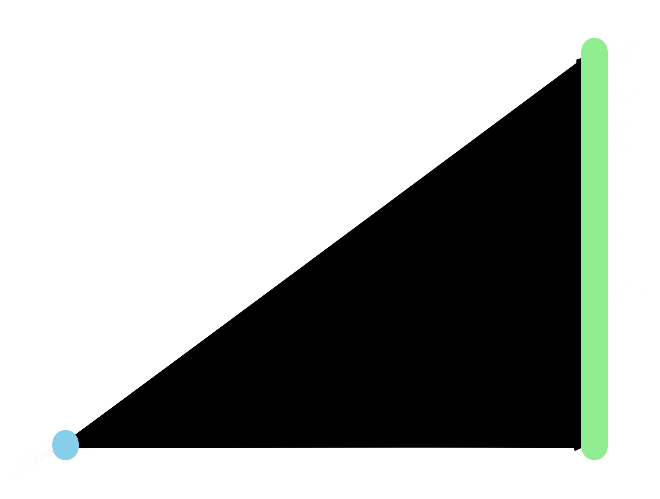

Total pharmaceutical companies: 24
Total doctors: 2026


In [8]:
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

left_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
right_nodes = set(G) - left_nodes
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(left_nodes))
pos.update((n, (2, i)) for i, n in enumerate(right_nodes))
nx.draw(G, pos, with_labels=False, node_color=['skyblue' if n in left_nodes else 'lightgreen' for n in G.nodes()])
plt.show()

pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}

print(f"Total pharmaceutical companies: {len(pharma_nodes)}")
print(f"Total doctors: {len(doctor_nodes)}")

In [9]:
pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
centrality = bipartite.degree_centrality(G, pharma_nodes)
pharma_centrality = {n: c for n, c in centrality.items() if n in pharma_nodes}
for node, centrality_score in pharma_centrality.items():
    print(f"{node}: {centrality_score:.4f}")

Collegium Pharmaceutical, Inc.: 0.1422
Mallinckrodt LLC: 0.0010
Mylan Specialty L.P.: 0.0227
Akrimax Pharmaceuticals, LLC: 0.0064
Egalet US Inc: 0.0582
Depomed, Inc.: 0.2878
Sentynl Therapeutics, Inc.: 0.0311
BioDelivery Sciences International, Inc.: 0.0647
Braeburn Pharmaceuticals, Inc.: 0.0395
Endo Pharmaceuticals Inc.: 0.0015
Vertical Pharmaceuticals, LLC: 0.0370
Purdue Transdermal Technologies L.P.: 0.0005
PFIZER INC.: 0.0933
Purdue Pharma L.P.: 0.4768
Mylan Pharmaceuticals Inc.: 0.0123
Indivior Inc.: 0.1624
Pernix Therapeutics Holdings, Inc.: 0.1022
INSYS Therapeutics Inc: 0.0997
Mission Pharmacal Company: 0.0104
The Medicines Company: 0.0138
Daiichi Sankyo Inc.: 0.1037
Mylan Institutional Inc.: 0.0039
Fresenius Kabi USA, LLC: 0.0005
Orexo US, Inc.: 0.0582


In [10]:
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}
centrality = bipartite.degree_centrality(G, doctor_nodes)
doctor_centrality = {n: c for n, c in centrality.items() if n in doctor_nodes}
df = pd.DataFrame.from_dict(doctor_centrality, orient='index', columns=['degree_centrality'])
df.index.name = 'doctor_id' 
df.to_csv("doctor_degree_centrality.csv")

In [11]:
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
pharma_hubs = {n: h for n, h in hubs.items() if G.nodes[n].get("bipartite") == 0}
doctor_authorities = {n: a for n, a in authorities.items() if G.nodes[n].get("bipartite") == 1}
pharma_df = pd.DataFrame.from_dict(pharma_hubs, orient='index', columns=['hub_score'])
pharma_df.index.name = 'pharma_company'
pharma_df.to_csv("pharma_hub_scores.csv")
doctor_df = pd.DataFrame.from_dict(doctor_authorities, orient='index', columns=['authority_score'])
doctor_df.index.name = 'doctor_id'
doctor_df.to_csv("doctor_authority_scores.csv")

In [ ]:
import os
import pyproj
os.environ["PROJ_DATA"] = "/opt/homebrew/share/proj"
pyproj.datadir.set_data_dir(os.environ["PROJ_DATA"])

df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})
df_zips["Recipient_Zip_Code"] = df_zips["Recipient_Zip_Code"].str[:5].str.zfill(5)
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
doctor_ids_in_G = {
    str(n).split(".")[0].strip().zfill(10)
    for n, d in G.nodes(data=True)
    if d.get("bipartite") == 1
}
df_zips = df_zips[df_zips["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/3187332366.py:1: DtypeWarning: Columns (4,10,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})


In [ ]:
df_payments["Covered_Recipient_NPI"] = df_payments["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
df_zips = df_zips.rename(columns={"Covered_Recipient_NPI": "doctor_id", "Recipient_Zip_Code": "zip"})
print("✅ Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (3385, 2)
Sample matched ZIPs: ['19030' '19115' '18344' '17403' '17112']


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/2212808955.py:43: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1109/2212808955.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


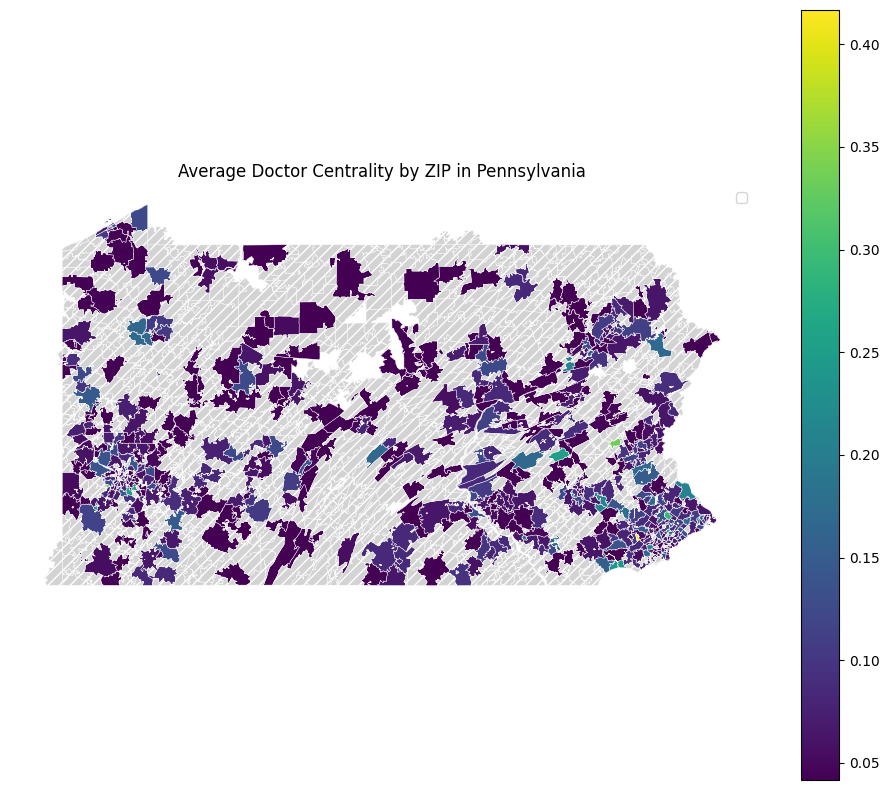

In [ ]:
import geopandas as gpd

zip_shapes = gpd.read_file("pa_zip_shapefile.shp")
zip_shapes = zip_shapes.rename(columns={"ZCTA5CE": "zip"})
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)

df_centrality = pd.read_csv("doctor_degree_centrality.csv", dtype=str)
df_centrality["doctor_id"] = df_centrality["doctor_id"].str.split(".").str[0].str.zfill(10)

df_joined = pd.merge(df_centrality, df_zips, on="doctor_id", how="inner")

df_joined["degree_centrality"] = df_joined["degree_centrality"].astype(float)
df_by_zip = df_joined.groupby("zip").agg(
    avg_centrality=("degree_centrality", "mean"),
    doctor_count=("doctor_id", "count")
).reset_index()

zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)
df_by_zip["zip"] = df_by_zip["zip"].astype(str).str.zfill(5)

merged = zip_shapes.merge(df_by_zip, on="zip", how="left")

fig, ax = plt.subplots(figsize=(12, 10))

merged.plot(
    column="avg_centrality",
    cmap="viridis",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",         # or 'whitesmoke', 'gainsboro', etc.
        "edgecolor": "white",
        "hatch": "///",               # optional: show a hatch for missing ZIPs
        "label": "No data"
    }
)

plt.title("Average Doctor Centrality by ZIP in Pennsylvania")
plt.axis("off")
plt.legend()
plt.show()